In [1]:
# --- Cell 1 ---
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# Optional: larger plots
plt.rcParams["figure.figsize"] = (8, 8)


# Uttar Pradesh

In [2]:
# --- Cell 2 ---
geojson_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/regions/shapes/uttar_pradesh.geojson"

# Read
up = gpd.read_file(geojson_path)

# Ensure it has a CRS; if missing, assume WGS84
if up.crs is None:
    up = up.set_crs("EPSG:4326")

print(up.crs)
up.head()


EPSG:4326


,Name,geometry
0,uttar_pradesh,"POLYGON ((77.59189 30.40632, 77.59337 30.40621..."


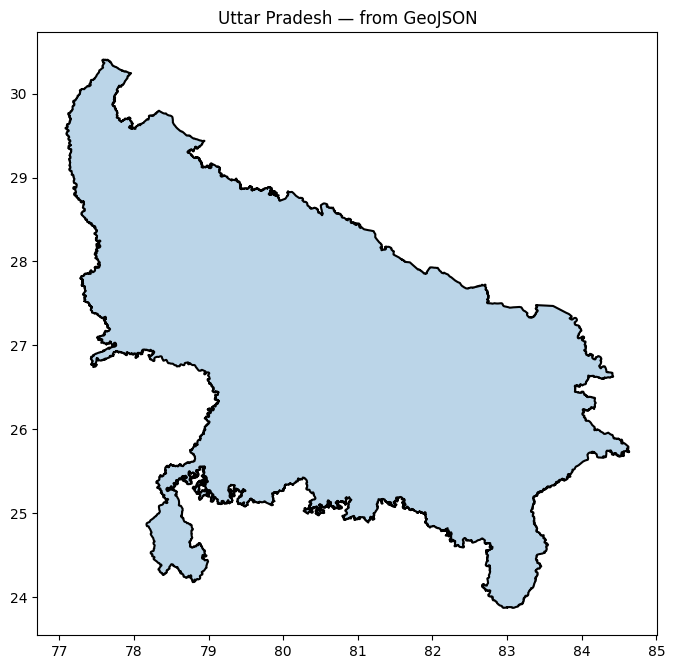

In [3]:
# --- Cell 3 ---
ax = up.boundary.plot(linewidth=1.5, edgecolor="black")
up.plot(ax=ax, alpha=0.3)
ax.set_title("Uttar Pradesh — from GeoJSON")
plt.show()


In [4]:
# --- Cell 4 ---
# For area/lengths, project to an appropriate metric CRS
# India-wide equal-area: EPSG:7755 (India National Equal Area) or use UTM zone covering UP (e.g., EPSG:32644/45).
up_aea = up.to_crs(7755)

# Bounds in meters (approx, in this CRS)
minx, miny, maxx, maxy = up_aea.total_bounds
width_km  = (maxx - minx) / 1000
height_km = (maxy - miny) / 1000
area_km2  = up_aea.area.sum() / 1e6

print(f"Bounding box (km): width ≈ {width_km:.1f}, height ≈ {height_km:.1f}")
print(f"Geodesic-like area in this projected CRS (km²): {area_km2:.0f}")


Bounding box (km): width ≈ 734.5, height ≈ 710.4
Geodesic-like area in this projected CRS (km²): 232448


In [5]:
# --- Cell 4 ---
# For area/lengths, project to an appropriate metric CRS
# India-wide equal-area: EPSG:7755 (India National Equal Area) or use UTM zone covering UP (e.g., EPSG:32644/45).
up_aea = up.to_crs(7755)

# Bounds in meters (approx, in this CRS)
minx, miny, maxx, maxy = up_aea.total_bounds
width_km  = (maxx - minx) / 1000
height_km = (maxy - miny) / 1000
area_km2  = up_aea.area.sum() / 1e6

print(f"Bounding box (km): width ≈ {width_km:.1f}, height ≈ {height_km:.1f}")
print(f"Geodesic-like area in this projected CRS (km²): {area_km2:.0f}")


Bounding box (km): width ≈ 734.5, height ≈ 710.4
Geodesic-like area in this projected CRS (km²): 232448


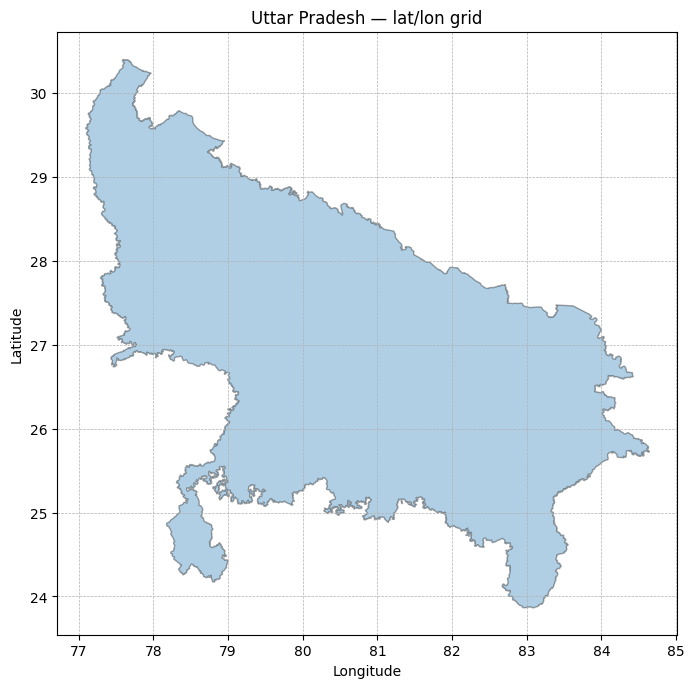

In [6]:
# --- Cell 5 ---
fig, ax = plt.subplots()
up.plot(ax=ax, alpha=0.35, edgecolor="black")
ax.set_title("Uttar Pradesh — lat/lon grid")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Target rectangle (km): width≈421.6, height≈237.2


/tmp/ipykernel_2266112/1034569281.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = up_proj.geometry.unary_union.centroid.coords[0]


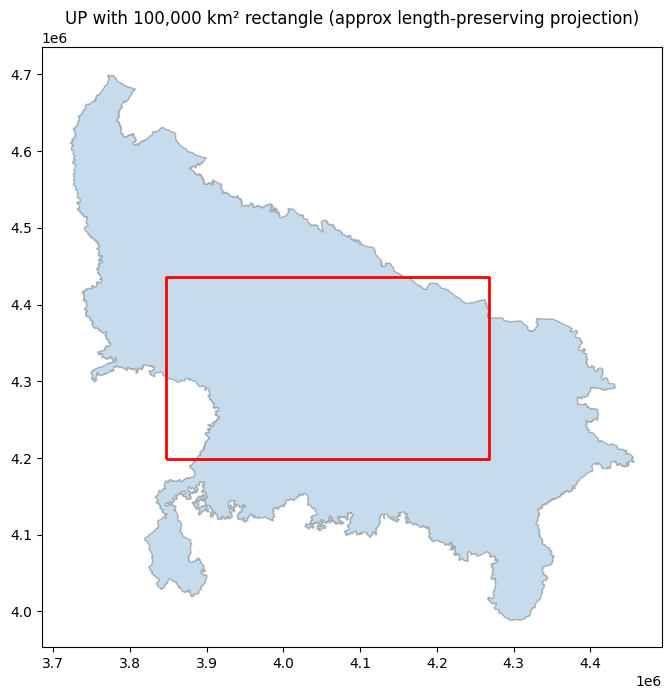

In [7]:
# --- Cell 6 (optional) ---
target_area_km2 = 100_000
aspect_w, aspect_h = 16, 9  # change if you like

# Compute target dimensions in km
import math
h_km = math.sqrt(target_area_km2 * (aspect_h / aspect_w))
w_km = target_area_km2 / h_km

print(f"Target rectangle (km): width≈{w_km:.1f}, height≈{h_km:.1f}")

# Work in the projected CRS for accurate sizing
up_proj = up.to_crs(7755)
cx, cy = up_proj.geometry.unary_union.centroid.coords[0]

# Build a rectangle centered on centroid
half_w = (w_km * 1000) / 2
half_h = (h_km * 1000) / 2
rect = box(cx - half_w, cy - half_h, cx + half_w, cy + half_h)
rect_gdf = gpd.GeoDataFrame(geometry=[rect], crs=up_proj.crs)

# Plot to verify
ax = up_proj.plot(alpha=0.25, edgecolor="black")
rect_gdf.boundary.plot(ax=ax, linewidth=2, color="red")
ax.set_title("UP with 100,000 km² rectangle (approx length-preserving projection)")
plt.show()


In [8]:
# --- Cell 6a ---
import math
import numpy as np
from shapely.affinity import translate
from shapely.geometry import box
import geopandas as gpd

# Work in a metric, equal-area CRS for India
up_proj = up.to_crs(7755)
P = up_proj.unary_union  # polygon

target_area_km2 = 100_000
aspect_w, aspect_h = 16, 9  # change if you want a different aspect

# Exact target size in km
h_km = math.sqrt(target_area_km2 * (aspect_h / aspect_w))
w_km = target_area_km2 / h_km
print(f"Target rectangle (km): width≈{w_km:.2f}, height≈{h_km:.2f}")

# Build a centered axis-aligned rectangle (at origin, meters)
half_w_m = (w_km * 1000) / 2.0
half_h_m = (h_km * 1000) / 2.0
rect0 = box(-half_w_m, -half_h_m, half_w_m, half_h_m)

# A small containment check helper
def fits_inside(poly, geom):
    # .covers allows boundary touch; use .contains to require strict interior
    return poly.covers(geom)


Target rectangle (km): width≈421.64, height≈237.17


/tmp/ipykernel_2266112/3649856378.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  P = up_proj.unary_union  # polygon


In [9]:
# --- Cell 6b ---
# Try to place the exact-size rectangle around the polygon centroid by small offsets
cx, cy = P.centroid.coords[0]

# Search grid offsets in meters (±150 km, step 10 km)
offsets_km = np.arange(-150, 151, 10)
best_rect = None

for dy_km in offsets_km:
    for dx_km in offsets_km:
        test_rect = translate(rect0, xoff=cx + dx_km*1000, yoff=cy + dy_km*1000)
        if fits_inside(P, test_rect):
            best_rect = test_rect
            break
    if best_rect is not None:
        break

if best_rect is None:
    print("No exact-size placement found; will try tiny shrink in the next cell.")
else:
    print("Exact-size placement found ✅")


No exact-size placement found; will try tiny shrink in the next cell.


In [11]:
# --- Cell 7a ---
import math
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# Project to an India equal-area CRS for correct km² areas
up_eq = up.to_crs(7755)            # EPSG:7755 (India National Equal Area)
UP_POLY = unary_union(up_eq.geometry)  # merged UP shape

TARGET_KM2 = 100_000
TOL = 0.001 * TARGET_KM2           # 0.1% tolerance

def area_km2(geom):
    return gpd.GeoSeries([geom], crs=up_eq.crs).area.iloc[0] / 1e6


In [12]:
# --- Cell 7b ---
from shapely.geometry import Polygon

# Center at UP centroid (you can change to any point you prefer inside UP)
cx, cy = UP_POLY.centroid.coords[0]

def clipped_circle_area_km2(radius_km):
    circle = Point(cx, cy).buffer(radius_km * 1000.0, resolution=256)  # high resolution circle
    clip = UP_POLY.intersection(circle)
    return area_km2(clip), clip

# Bracket the solution: start with small & large radii
lo_km, hi_km = 5.0, 1000.0
alo, _ = clipped_circle_area_km2(lo_km)
ahi, _ = clipped_circle_area_km2(hi_km)

if alo > TARGET_KM2:
    raise RuntimeError("Even a tiny radius exceeds target—unexpected; check CRS.")
if ahi < TARGET_KM2:
    raise RuntimeError("Even a huge radius is too small—UP area may be < target?")

# Bisection
best_clip = None
for _ in range(60):  # plenty for convergence
    mid_km = 0.5 * (lo_km + hi_km)
    amid, clip = clipped_circle_area_km2(mid_km)
    best_clip = clip
    if abs(amid - TARGET_KM2) <= TOL:
        print(f"Converged: r ≈ {mid_km:.2f} km, area ≈ {amid:.1f} km²")
        break
    if amid < TARGET_KM2:
        lo_km = mid_km
    else:
        hi_km = mid_km
else:
    # If loop didn't break, take the better of lo/hi
    alo, clip_lo = clipped_circle_area_km2(lo_km)
    ahi, clip_hi = clipped_circle_area_km2(hi_km)
    if abs(alo - TARGET_KM2) < abs(ahi - TARGET_KM2):
        best_clip = clip_lo
        print(f"Near best: r ≈ {lo_km:.2f} km, area ≈ {alo:.1f} km²")
    else:
        best_clip = clip_hi
        print(f"Near best: r ≈ {hi_km:.2f} km, area ≈ {ahi:.1f} km²")

sel = gpd.GeoDataFrame(geometry=[best_clip], crs=up_eq.crs)
print(f"Selected region area ≈ {sel.area.iloc[0]/1e6:.1f} km²")


Converged: r ≈ 182.57 km, area ≈ 100063.6 km²
Selected region area ≈ 100063.6 km²


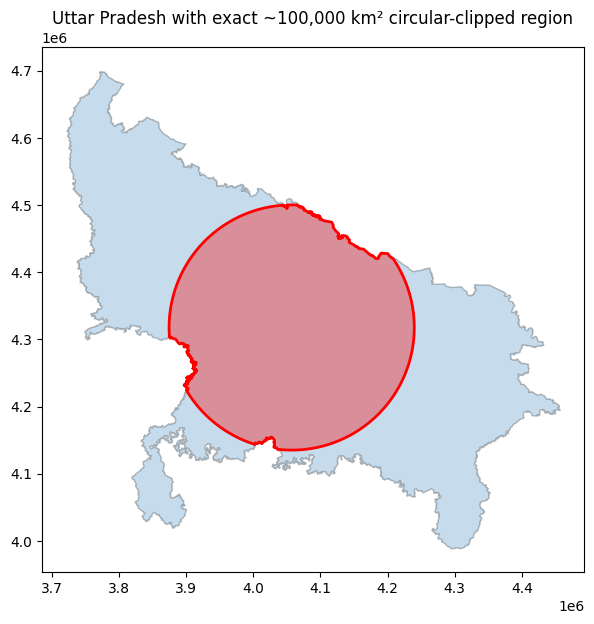

In [14]:
# --- Cell 7c ---
ax = up_eq.plot(alpha=0.25, edgecolor="black", figsize=(7,7))
sel.boundary.plot(ax=ax, color="red", linewidth=2)
sel.plot(ax=ax, alpha=0.35, color="red")
ax.set_title("Uttar Pradesh with exact ~100,000 km² circular-clipped region")
plt.show()


In [18]:
# --- Cell 7d ---
out_proj = "./up_region_100k_eqarea.geojson"
out_wgs  = "./uttar_pradesh_100k.geojson"
sel.to_file(out_proj, driver="GeoJSON")
sel.to_crs(4326).to_file(out_wgs, driver="GeoJSON")
print("Saved:")
print("  ", out_proj)
print("  ", out_wgs)


Saved:
   ./up_region_100k_eqarea.geojson
   ./uttar_pradesh_100k.geojson


In [23]:
import geopandas as gpd

# Load the GeoJSON file
file_path = "uttar_pradesh_100k.geojson"
gdf = gpd.read_file(file_path)

# Reproject to a CRS suitable for area calculation (e.g., World Mollweide)
gdf = gdf.to_crs("EPSG:7755")  # EPSG:7755 is in meters

# Calculate area in square meters and convert to square kilometers
gdf['area_sqkm'] = gdf['geometry'].area / 10**6

# Print the total area
total_area = gdf['area_sqkm'].sum()
print(f"Total area: {total_area} square kilometers")

Total area: 100063.58362760405 square kilometers


In [26]:
# --- Cell 8a ---
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union

def split_equal_area(sel_gdf, orientation="horizontal", tol_km2=5.0, max_iter=60):
    """
    Split the polygon in sel_gdf (equal-area CRS) into two equal-area parts
    using a straight cut and bisection.
    orientation: "horizontal" (y = const) or "vertical" (x = const)
    tol_km2: acceptable absolute area error (km^2) from half
    """
    crs = sel_gdf.crs
    poly = unary_union(sel_gdf.geometry)
    total_area_km2 = gpd.GeoSeries([poly], crs=crs).area.iloc[0] / 1e6
    target = 0.5 * total_area_km2

    minx, miny, maxx, maxy = poly.bounds

    def area_below_y(y_cut):
        # half-plane polygon below y_cut (big rectangle)
        clipper = box(minx - 1e6, miny - 1e6, maxx + 1e6, y_cut)
        inter = poly.intersection(clipper)
        return gpd.GeoSeries([inter], crs=crs).area.iloc[0] / 1e6, inter

    def area_left_x(x_cut):
        clipper = box(minx - 1e6, miny - 1e6, x_cut, maxy + 1e6)
        inter = poly.intersection(clipper)
        return gpd.GeoSeries([inter], crs=crs).area.iloc[0] / 1e6, inter

    if orientation == "horizontal":
        lo, hi = miny, maxy
        best = None
        for _ in range(max_iter):
            mid = 0.5 * (lo + hi)
            a_mid, inter = area_below_y(mid)
            best = (a_mid, inter, mid)
            if abs(a_mid - target) <= tol_km2:
                break
            if a_mid < target:
                lo = mid
            else:
                hi = mid
        a_mid, inter, y_cut = best
        partA = inter
        partB = poly.difference(inter)

    elif orientation == "vertical":
        lo, hi = minx, maxx
        best = None
        for _ in range(max_iter):
            mid = 0.5 * (lo + hi)
            a_mid, inter = area_left_x(mid)
            best = (a_mid, inter, mid)
            if abs(a_mid - target) <= tol_km2:
                break
            if a_mid < target:
                lo = mid
            else:
                hi = mid
        a_mid, inter, x_cut = best
        partA = inter
        partB = poly.difference(inter)
    else:
        raise ValueError("orientation must be 'horizontal' or 'vertical'")

    A = gpd.GeoDataFrame(geometry=[partA], crs=crs)
    B = gpd.GeoDataFrame(geometry=[partB], crs=crs)
    areaA = A.area.iloc[0] / 1e6
    areaB = B.area.iloc[0] / 1e6
    return A, B, areaA, areaB, total_area_km2


In [28]:

# If you'd prefer a vertical cut, run:
A, B, areaA, areaB, total = split_equal_area(sel, orientation="vertical", tol_km2=2.0)

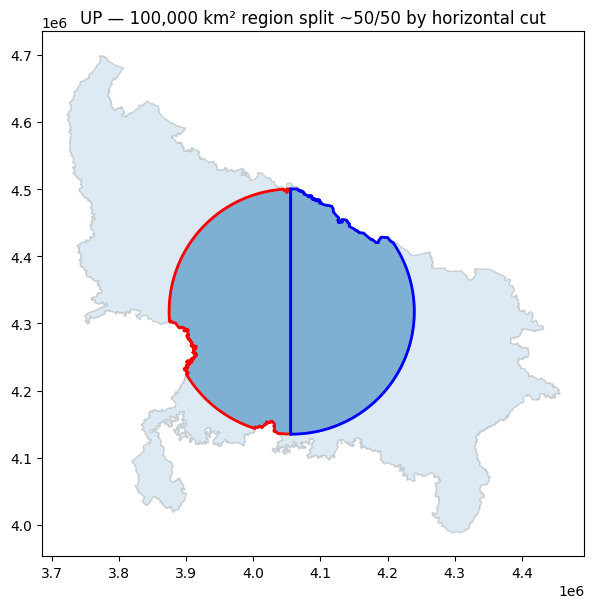

In [29]:
# --- Cell 8c ---
ax = up_eq.plot(alpha=0.15, edgecolor="black", figsize=(7,7))  # UP outline (eq-area CRS)
A.plot(ax=ax, alpha=0.5, edgecolor="red")
B.plot(ax=ax, alpha=0.5, edgecolor="blue")
A.boundary.plot(ax=ax, color="red", linewidth=2)
B.boundary.plot(ax=ax, color="blue", linewidth=2)
ax.set_title("UP — 100,000 km² region split ~50/50 by horizontal cut")
plt.show()


In [30]:
# --- Cell 8d ---
A.to_file("./uttar_pradesh_100k_train_eqarea.geojson", driver="GeoJSON")
B.to_file("./uttar_pradesh_100k_test_eqarea.geojson", driver="GeoJSON")

A.to_crs(4326).to_file("./uttar_pradesh_100k_train.geojson", driver="GeoJSON")
B.to_crs(4326).to_file("./uttar_pradesh_100k_test.geojson", driver="GeoJSON")

print("Saved:")
print("  ./uttar_pradesh_100k_train_eqarea.geojson")
print("  ./uttar_pradesh_100k_test_eqarea.geojson")
print("  ./uttar_pradesh_100k_train.geojson")
print("  ./uttar_pradesh_100k_test.geojson")


Saved:
  ./uttar_pradesh_100k_train_eqarea.geojson
  ./uttar_pradesh_100k_test_eqarea.geojson
  ./uttar_pradesh_100k_train.geojson
  ./uttar_pradesh_100k_test.geojson


# Pakistan’s Punjab

In [31]:
# --- Cell 1 ---
import geopandas as gpd
from shapely.ops import unary_union

pak_punjab_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/regions/shapes/pak_punjab.geojson"

punjab = gpd.read_file(pak_punjab_path)

# Ensure CRS set
if punjab.crs is None:
    punjab = punjab.set_crs("EPSG:4326")

# Project to equal-area CRS (India/Nearby covers Pakistan too) for km² accuracy
punjab_eq = punjab.to_crs(7755)
P_POLY = unary_union(punjab_eq.geometry)

print("Punjab area (km²):", gpd.GeoSeries([P_POLY], crs=punjab_eq.crs).area.iloc[0]/1e6)


Punjab area (km²): 200796.44644797887


In [32]:
# --- Cell 2 ---
from shapely.geometry import Point

TARGET_KM2 = 100_000
TOL = 0.001 * TARGET_KM2

cx, cy = P_POLY.centroid.coords[0]

def area_km2(geom):
    return gpd.GeoSeries([geom], crs=punjab_eq.crs).area.iloc[0] / 1e6

def clipped_circle_area_km2(radius_km):
    circle = Point(cx, cy).buffer(radius_km*1000, resolution=256)
    clip = P_POLY.intersection(circle)
    return area_km2(clip), clip

lo_km, hi_km = 5.0, 1000.0
best_clip = None

for _ in range(60):
    mid = 0.5*(lo_km+hi_km)
    amid, clip = clipped_circle_area_km2(mid)
    best_clip = clip
    if abs(amid - TARGET_KM2) <= TOL:
        break
    if amid < TARGET_KM2:
        lo_km = mid
    else:
        hi_km = mid

sel_punjab = gpd.GeoDataFrame(geometry=[best_clip], crs=punjab_eq.crs)
print("Selected Punjab region ≈", sel_punjab.area.iloc[0]/1e6, "km²")


Selected Punjab region ≈ 99912.38989225833 km²


In [33]:
# --- Cell 2 ---
from shapely.geometry import Point

TARGET_KM2 = 100_000
TOL = 0.001 * TARGET_KM2

cx, cy = P_POLY.centroid.coords[0]

def area_km2(geom):
    return gpd.GeoSeries([geom], crs=punjab_eq.crs).area.iloc[0] / 1e6

def clipped_circle_area_km2(radius_km):
    circle = Point(cx, cy).buffer(radius_km*1000, resolution=256)
    clip = P_POLY.intersection(circle)
    return area_km2(clip), clip

lo_km, hi_km = 5.0, 1000.0
best_clip = None

for _ in range(60):
    mid = 0.5*(lo_km+hi_km)
    amid, clip = clipped_circle_area_km2(mid)
    best_clip = clip
    if abs(amid - TARGET_KM2) <= TOL:
        break
    if amid < TARGET_KM2:
        lo_km = mid
    else:
        hi_km = mid

sel_punjab = gpd.GeoDataFrame(geometry=[best_clip], crs=punjab_eq.crs)
print("Selected Punjab region ≈", sel_punjab.area.iloc[0]/1e6, "km²")


Selected Punjab region ≈ 99912.38989225833 km²


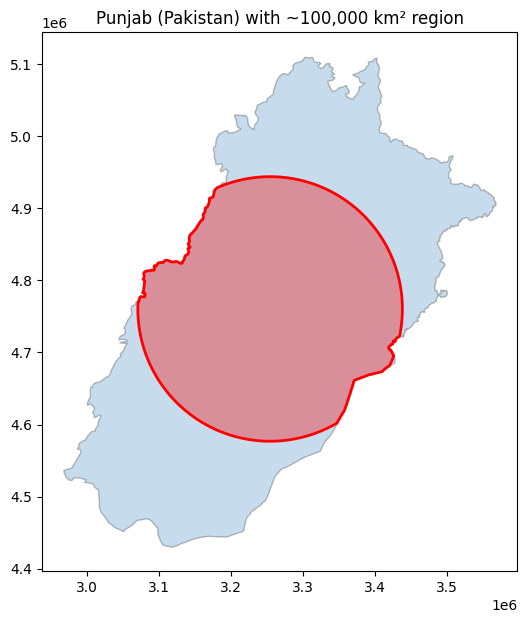

In [34]:
# --- Cell 3 ---
import matplotlib.pyplot as plt

ax = punjab_eq.plot(alpha=0.25, edgecolor="black", figsize=(7,7))
sel_punjab.boundary.plot(ax=ax, color="red", linewidth=2)
sel_punjab.plot(ax=ax, alpha=0.35, color="red")
ax.set_title("Punjab (Pakistan) with ~100,000 km² region")
plt.show()


In [35]:
# --- Cell 4 ---
A, B, areaA, areaB, total = split_equal_area(sel_punjab, orientation="horizontal", tol_km2=2.0)

print(f"Total ≈ {total:.1f} km²")
print(f"Part A ≈ {areaA:.1f} km²")
print(f"Part B ≈ {areaB:.1f} km²")


Total ≈ 99912.4 km²
Part A ≈ 49957.6 km²
Part B ≈ 49954.8 km²


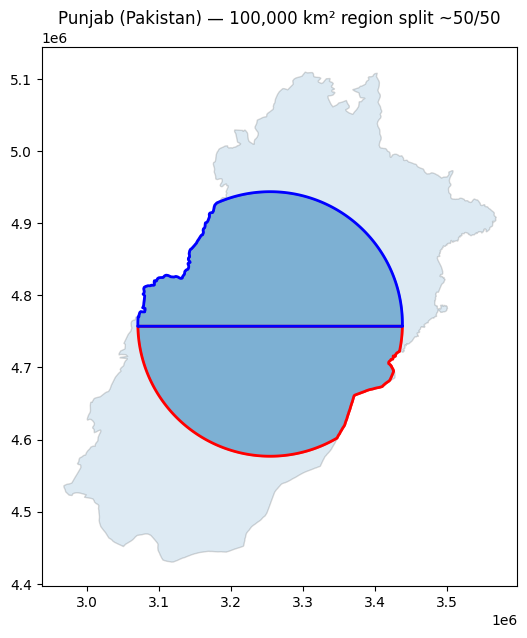

In [36]:
# --- Cell 5 ---
ax = punjab_eq.plot(alpha=0.15, edgecolor="black", figsize=(7,7))
A.plot(ax=ax, alpha=0.5, edgecolor="red")
B.plot(ax=ax, alpha=0.5, edgecolor="blue")
A.boundary.plot(ax=ax, color="red", linewidth=2)
B.boundary.plot(ax=ax, color="blue", linewidth=2)
ax.set_title("Punjab (Pakistan) — 100,000 km² region split ~50/50")
plt.show()


In [37]:
# --- Cell 6 ---
A.to_file("./pak_punjab_100k_train_eqarea.geojson", driver="GeoJSON")
B.to_file("./pak_punjab_100k_test_eqarea.geojson", driver="GeoJSON")

A.to_crs(4326).to_file("./pak_punjab_100k_train_wgs84.geojson", driver="GeoJSON")
B.to_crs(4326).to_file("./pak_punjab_100k_test_wgs84.geojson", driver="GeoJSON")

print("Saved 4 files for Punjab (Eq-area + WGS84, Part A & B)")


Saved 4 files for Punjab (Eq-area + WGS84, Part A & B)


# Bangladesh

In [38]:
# --- Cell 1 ---
import geopandas as gpd
from shapely.ops import unary_union

bangladesh_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/regions/shapes/bangladesh.geojson"

bd = gpd.read_file(bangladesh_path)

# Ensure CRS set
if bd.crs is None:
    bd = bd.set_crs("EPSG:4326")

# Project to equal-area CRS for km² accuracy
bd_eq = bd.to_crs(7755)
BD_POLY = unary_union(bd_eq.geometry)

print("Bangladesh area (km²):", gpd.GeoSeries([BD_POLY], crs=bd_eq.crs).area.iloc[0]/1e6)


Bangladesh area (km²): 134520.7471666744


In [39]:
# --- Cell 2 ---
from shapely.geometry import Point

TARGET_KM2 = 100_000
TOL = 0.001 * TARGET_KM2

cx, cy = BD_POLY.centroid.coords[0]

def area_km2(geom):
    return gpd.GeoSeries([geom], crs=bd_eq.crs).area.iloc[0] / 1e6

def clipped_circle_area_km2(radius_km):
    circle = Point(cx, cy).buffer(radius_km*1000, resolution=256)
    clip = BD_POLY.intersection(circle)
    return area_km2(clip), clip

lo_km, hi_km = 5.0, 1000.0
best_clip = None

for _ in range(60):
    mid = 0.5*(lo_km+hi_km)
    amid, clip = clipped_circle_area_km2(mid)
    best_clip = clip
    if abs(amid - TARGET_KM2) <= TOL:
        break
    if amid < TARGET_KM2:
        lo_km = mid
    else:
        hi_km = mid

sel_bd = gpd.GeoDataFrame(geometry=[best_clip], crs=bd_eq.crs)
print("Selected Bangladesh region ≈", sel_bd.area.iloc[0]/1e6, "km²")


Selected Bangladesh region ≈ 100068.5332891202 km²


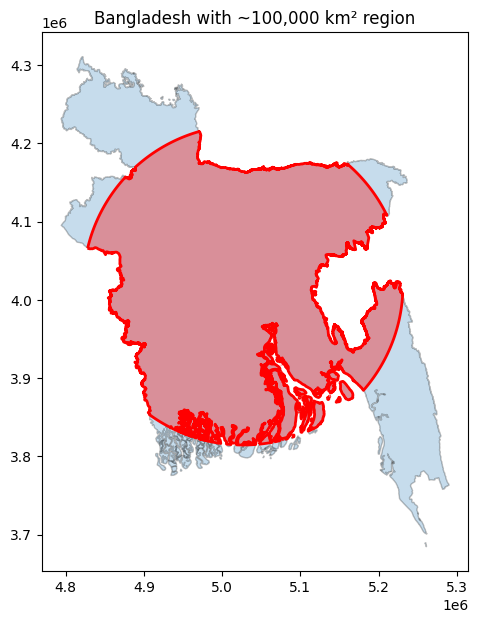

In [40]:
# --- Cell 3 ---
import matplotlib.pyplot as plt

ax = bd_eq.plot(alpha=0.25, edgecolor="black", figsize=(7,7))
sel_bd.boundary.plot(ax=ax, color="red", linewidth=2)
sel_bd.plot(ax=ax, alpha=0.35, color="red")
ax.set_title("Bangladesh with ~100,000 km² region")
plt.show()


In [42]:
# --- Cell 4 ---
A, B, areaA, areaB, total = split_equal_area(sel_bd, orientation="horizontal", tol_km2=2.0)

print(f"Total ≈ {total:.1f} km²")
print(f"Part A ≈ {areaA:.1f} km²")
print(f"Part B ≈ {areaB:.1f} km²")


Total ≈ 100068.5 km²
Part A ≈ 50035.7 km²
Part B ≈ 50032.8 km²


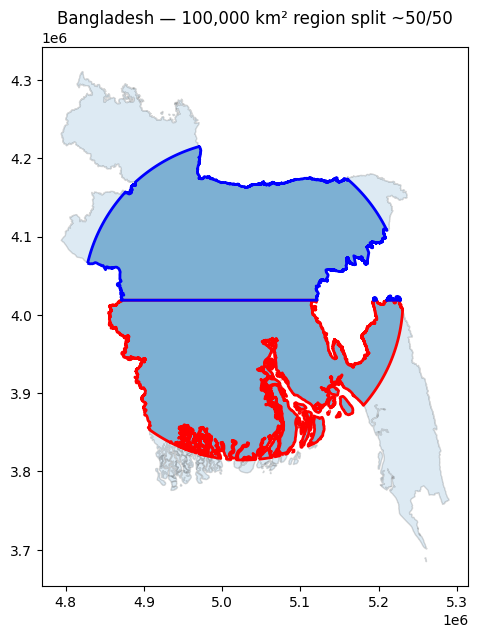

In [43]:
# --- Cell 5 ---
ax = bd_eq.plot(alpha=0.15, edgecolor="black", figsize=(7,7))
A.plot(ax=ax, alpha=0.5, edgecolor="red")
B.plot(ax=ax, alpha=0.5, edgecolor="blue")
A.boundary.plot(ax=ax, color="red", linewidth=2)
B.boundary.plot(ax=ax, color="blue", linewidth=2)
ax.set_title("Bangladesh — 100,000 km² region split ~50/50")
plt.show()


In [44]:
# --- Cell 6 ---
A.to_file("./bangladesh_100k_train_eqarea.geojson", driver="GeoJSON")
B.to_file("./bangladesh_100k_test_eqarea.geojson", driver="GeoJSON")

A.to_crs(4326).to_file("./bangladesh_100k_train_wgs84.geojson", driver="GeoJSON")
B.to_crs(4326).to_file("./bangladesh_100k_test_wgs84.geojson", driver="GeoJSON")

print("Saved 4 files for Bangladesh (Eq-area + WGS84, Part A & B)")


Saved 4 files for Bangladesh (Eq-area + WGS84, Part A & B)


# Image fetching 

In [45]:
# --- Cell 1 ---
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union

# Choose the spatial relation:
#   "intersects" → tile touches/overlaps region (most inclusive)
#   "within"     → tile is fully inside region (stricter)
PREDICATE = "intersects"  # change to "within" if you want strict containment


In [71]:
# --- Cell 2 ---
# Load WGS84 versions (lat/lon) that you saved earlier
partA_wgs = gpd.read_file("./pak_punjab_100k_train_wgs84.geojson")
partB_wgs = gpd.read_file("./pak_punjab_100k_test_wgs84.geojson")

# Ensure CRS is set
if partA_wgs.crs is None: partA_wgs = partA_wgs.set_crs(4326)
if partB_wgs.crs is None: partB_wgs = partB_wgs.set_crs(4326)

# Project to equal-area CRS for robust geometry ops
partA = partA_wgs.to_crs(7755)   # EPSG:7755 (India National Equal Area)
partB = partB_wgs.to_crs(7755)

# Merge multiparts if any
partA_poly = gpd.GeoDataFrame(geometry=[unary_union(partA.geometry)], crs=partA.crs)
partB_poly = gpd.GeoDataFrame(geometry=[unary_union(partB.geometry)], crs=partB.crs)


In [72]:
# --- Cell 3 ---
meta_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/patch_metadata/pak_punjab_metadata.geojson"
tiles = gpd.read_file(meta_path)

# The file says CRS84; treat as EPSG:4326
if tiles.crs is None:
    tiles = tiles.set_crs(4326)

# Reproject to equal-area to match parts
tiles_eq = tiles.to_crs(7755)

# Quick sanity checks
print("Tiles:", len(tiles_eq))
print("Example columns:", tiles_eq.columns.tolist()[:8])


Tiles: 289548
Example columns: ['tile_name', 'lon_center', 'lat_center', 'geometry']


In [73]:
# --- Cell 4 ---
# Prepare region labels for join
partA_poly["part"] = "PartA"
partB_poly["part"] = "PartB"
regions = pd.concat([partA_poly, partB_poly], ignore_index=True)

# Spatial join
joined = gpd.sjoin(tiles_eq, regions, how="left", predicate=PREDICATE)

# Tiles in A / B / neither
tiles_in_A = joined[joined["part"] == "PartA"].copy()
tiles_in_B = joined[joined["part"] == "PartB"].copy()
tiles_out  = joined[joined["part"].isna()].copy()

print(f"In Part A: {len(tiles_in_A)}")
print(f"In Part B: {len(tiles_in_B)}")
print(f"In neither: {len(tiles_out)}")


In Part A: 70158
In Part B: 70763
In neither: 149308


In [74]:
# --- Cell 5 ---
# Helpful columns to keep
keep_cols = ["tile_name", "lon_center", "lat_center"]

def safe_cols(df):
    cols = [c for c in keep_cols if c in df.columns]
    return df[cols].copy() if cols else pd.DataFrame(index=df.index)

# CSV lists
safe_cols(tiles_in_A).to_csv("./pak_punjab_tiles_in_train.csv", index=False)
safe_cols(tiles_in_B).to_csv("./pak_punjab_tiles_in_test.csv", index=False)
safe_cols(tiles_out ).to_csv("./pak_punjab_tiles_outside_parts.csv", index=False)

# GeoJSON subsets (keep original WGS84 geometries for easy map use)
tiles_in_A_wgs = tiles.loc[tiles_eq.index.isin(tiles_in_A.index)].copy()
tiles_in_B_wgs = tiles.loc[tiles_eq.index.isin(tiles_in_B.index)].copy()
tiles_out_wgs  = tiles.loc[tiles_eq.index.isin(tiles_out.index )].copy()

tiles_in_A_wgs.to_file("./pak_punjab_tiles_in_train.geojson", driver="GeoJSON")
tiles_in_B_wgs.to_file("./pak_punjab_tiles_in_test.geojson", driver="GeoJSON")
tiles_out_wgs .to_file("./pak_punjab_tiles_outside_parts.geojson", driver="GeoJSON")

print("Saved:")
print("  ./pak_punjab_tiles_in_train.csv")
print("  ./pak_punjab_tiles_in_test.csv")
print("  ./pak_punjab_tiles_outside_parts.csv")
print("  ./pak_punjab_tiles_in_train.geojson")
print("  ./pak_punjab_tiles_in_test.geojson")
print("  ./pak_punjab_tiles_outside_parts.geojson")


Saved:
  ./pak_punjab_tiles_in_train.csv
  ./pak_punjab_tiles_in_test.csv
  ./pak_punjab_tiles_outside_parts.csv
  ./pak_punjab_tiles_in_train.geojson
  ./pak_punjab_tiles_in_test.geojson
  ./pak_punjab_tiles_outside_parts.geojson


/tmp/ipykernel_2266112/2727450368.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower right", markerscale=4)


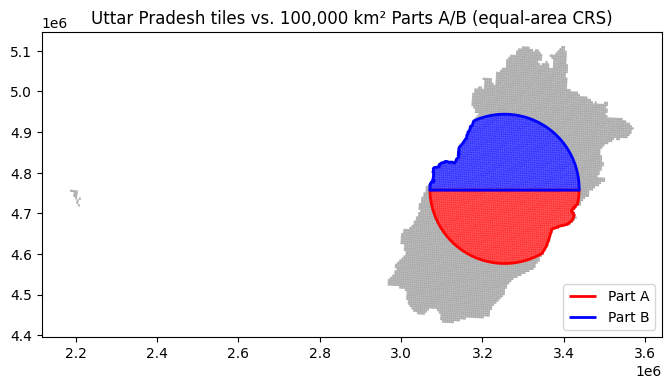

In [75]:
# --- Cell 6 ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
# Plot Bangladesh boundary (optional if you have it)
# bd_eq.plot(ax=ax, alpha=0.1, edgecolor="gray")

partA_poly.boundary.plot(ax=ax, color="red", linewidth=2, label="Part A")
partB_poly.boundary.plot(ax=ax, color="blue", linewidth=2, label="Part B")

tiles_in_A.plot(ax=ax, markersize=2, color="red", alpha=0.6, label="Tiles in A")
tiles_in_B.plot(ax=ax, markersize=2, color="blue", alpha=0.6, label="Tiles in B")
tiles_out.plot(ax=ax, markersize=1, color="gray", alpha=0.4, label="Outside")

ax.set_title("Uttar Pradesh tiles vs. 100,000 km² Parts A/B (equal-area CRS)")
ax.legend(loc="lower right", markerscale=4)
plt.savefig("./pak_punjab_tiles_comparison.png", dpi=600)
plt.show()


In [76]:
# --- Cell 1 ---
import os, re, shutil
from pathlib import Path

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.ops import unary_union

# Input folders/files
IMG_DIR = Path("/mnt/nas_ramanujan/rishabh_sat/sentinel_patch_128_128/pak_punjab/rgb")
PARTA_PATH = Path("./pak_punjab_100k_train_wgs84.geojson")
PARTB_PATH = Path("./pak_punjab_100k_test_wgs84.geojson")

# Optional metadata (for extra sanity check)
META_PATH = Path("/mnt/nas_ramanujan/rishabh_sat/sentinel_patch_128_128/patch_metadata/pak_punjab_metadata.geojson")

# Output folders
OUT_ROOT   = Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/iclr_2026_processed_data/pak_punjab_split")
TRAIN_DIR  = OUT_ROOT / "train"  # Part A
TEST_DIR   = OUT_ROOT / "test"   # Part B

TRAIN_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)


In [77]:
# --- Cell 2 ---
partA = gpd.read_file(PARTA_PATH)
partB = gpd.read_file(PARTB_PATH)

# Ensure CRS
if partA.crs is None: partA = partA.set_crs(4326)
if partB.crs is None: partB = partB.set_crs(4326)

# Merge each into a single polygon (in case of multiparts)
partA = gpd.GeoDataFrame(geometry=[unary_union(partA.geometry)], crs=partA.crs)
partB = gpd.GeoDataFrame(geometry=[unary_union(partB.geometry)], crs=partB.crs)

# Quick info
print("Part A bounds:", partA.total_bounds)
print("Part B bounds:", partB.total_bounds)


Part A bounds: [70.17359236 29.11069335 74.050008   30.8433507 ]
Part B bounds: [70.16649852 30.65392878 74.0494573  32.46303566]


In [78]:
# --- Cell 3 ---
# Expect filenames like "lat_lon.png" (lat first, lon second), 4 decimals
pat = re.compile(r"^(-?\d+(?:\.\d+)?)_(-?\d+(?:\.\d+)?)\.png$", re.IGNORECASE)

rows = []
for p in IMG_DIR.glob("*.png"):
    m = pat.match(p.name)
    if not m:
        continue
    lat = float(m.group(1))
    lon = float(m.group(2))
    rows.append({"path": str(p), "lat": lat, "lon": lon})

imgs_df = pd.DataFrame(rows)
print("Total PNGs parsed:", len(imgs_df))

# Build GeoDataFrame of centers
imgs_gdf = gpd.GeoDataFrame(
    imgs_df,
    geometry=[Point(lon, lat) for lat, lon in zip(imgs_df["lat"], imgs_df["lon"])],
    crs=4326
)
imgs_gdf.head()


Total PNGs parsed: 289548


,path,lat,lon,geometry
0,/mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...,27.7540,70.8263,POINT (70.8263 27.754)
1,/mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...,28.0163,71.1061,POINT (71.1061 28.0163)
2,/mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...,28.2338,71.9264,POINT (71.9264 28.2338)
3,/mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...,28.3041,70.6763,POINT (70.6763 28.3041)
4,/mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...,28.3574,71.5763,POINT (71.5763 28.3574)


In [79]:
# --- Cell 4 ---
# Label regions for join
partA_l = partA.copy(); partA_l["subset"] = "train"
partB_l = partB.copy(); partB_l["subset"] = "test"

regions = pd.concat([partA_l, partB_l], ignore_index=True)

# Spatial join (points within polygons)
joined = gpd.sjoin(imgs_gdf, regions[["geometry", "subset"]], how="left", predicate="within")

# Split
train_imgs = joined[joined["subset"] == "train"].copy()
test_imgs  = joined[joined["subset"] == "test"].copy()
none_imgs  = joined[joined["subset"].isna()].copy()

print(f"Assigned to train (Part A): {len(train_imgs)}")
print(f"Assigned to test  (Part B): {len(test_imgs)}")
print(f"Unassigned (outside both): {len(none_imgs)}")

# Optional peek
display_cols = ["path", "lat", "lon", "subset"]
train_imgs[display_cols].head(5), test_imgs[display_cols].head(5), none_imgs[display_cols].head(5)


Assigned to train (Part A): 68777
Assigned to test  (Part B): 70210
Unassigned (outside both): 150561


(                                                 path      lat      lon subset
 20  /mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...  29.4041  71.7675  train
 21  /mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...  29.4838  71.0061  train
 22  /mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...  29.4838  73.0263  train
 23  /mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...  29.5163  71.1561  train
 24  /mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...  29.5926  72.1764  train,
                                                  path      lat      lon subset
 49  /mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...  30.6839  70.7351   test
 50  /mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...  30.7927  72.8561   test
 51  /mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...  30.8162  73.0027   test
 52  /mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...  30.8250  73.6175   test
 53  /mnt/nas_ramanujan/rishabh_sat/sentinel_patch_...  30.8839  73.8028   test,
                                      

In [80]:
# --- Cell 5 ---
def safe_copy(series_paths, dest_dir: Path):
    copied = 0
    for p in series_paths:
        src = Path(p)
        dst = dest_dir / src.name
        if not dst.exists():
            shutil.copy2(src, dst)
            copied += 1
    return copied

copied_train = safe_copy(train_imgs["path"], TRAIN_DIR)
copied_test  = safe_copy(test_imgs["path"],  TEST_DIR)

print(f"Copied to train: {copied_train} files")
print(f"Copied to test : {copied_test} files")


Copied to train: 68777 files
Copied to test : 70210 files


In [7]:
from pathlib import Path

# Paths
LABEL_DIR = Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels")
OUT_ROOT  = Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/iclr_2026_processed_data/bangladesh_split")
TRAIN_DIR = OUT_ROOT / "train"
TEST_DIR  = OUT_ROOT / "test"

# Gather image stems (without extension)
def stems_from_dir(img_dir):
    exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
    return {p.stem for p in img_dir.glob("*") if p.suffix.lower() in exts}

train_stems = stems_from_dir(TRAIN_DIR)
test_stems  = stems_from_dir(TEST_DIR)

# Gather available labels
label_stems = {p.stem for p in LABEL_DIR.glob("*.txt")}

# Count
train_with_labels = train_stems & label_stems
test_with_labels  = test_stems & label_stems

print(f"Train images total: {len(train_stems)}")
print(f"Train with labels : {len(train_with_labels)}")
print(f"Train without     : {len(train_stems - train_with_labels)}")

print(f"\nTest images total: {len(test_stems)}")
print(f"Test with labels : {len(test_with_labels)}")
print(f"Test without     : {len(test_stems - test_with_labels)}")


Train images total: 65902
Train with labels : 3437
Train without     : 62465

Test images total: 66913
Test with labels : 3421
Test without     : 63492


In [10]:
from pathlib import Path
import shutil

# Paths
LABEL_DIR = Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels")
OUT_ROOT  = Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/iclr_2026_processed_data/uttar_pradesh_split")
TRAIN_SRC = OUT_ROOT / "train"  # where you put images before
TEST_SRC  = OUT_ROOT / "test"

# Final target structure
TRAIN_IMG = OUT_ROOT / "train" / "images"
TRAIN_LAB = OUT_ROOT / "train" / "labels"
TEST_IMG  = OUT_ROOT / "test" / "images"
TEST_LAB  = OUT_ROOT / "test" / "labels"

for d in [TRAIN_IMG, TRAIN_LAB, TEST_IMG, TEST_LAB]:
    d.mkdir(parents=True, exist_ok=True)

# Utility to collect stems
def stems_from_dir(img_dir):
    exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
    return {p.stem: p for p in img_dir.glob("*") if p.suffix.lower() in exts}

train_stems = stems_from_dir(TRAIN_SRC)
test_stems  = stems_from_dir(TEST_SRC)
label_stems = {p.stem: p for p in LABEL_DIR.glob("*.txt")}

# Copy helper
def copy_pairs(stems_dict, dest_img_dir, dest_lab_dir):
    copied_img, copied_lab = 0, 0
    for stem, img_path in stems_dict.items():
        # Only copy if a label exists
        if stem in label_stems:
            # Copy image
            dst_img = dest_img_dir / img_path.name
            if not dst_img.exists():
                shutil.copy2(img_path, dst_img)
                copied_img += 1
            # Copy label
            lbl_path = label_stems[stem]
            dst_lbl = dest_lab_dir / lbl_path.name
            if not dst_lbl.exists():
                shutil.copy2(lbl_path, dst_lbl)
                copied_lab += 1
    return copied_img, copied_lab

train_img_copied, train_lbl_copied = copy_pairs(train_stems, TRAIN_IMG, TRAIN_LAB)
test_img_copied,  test_lbl_copied  = copy_pairs(test_stems,  TEST_IMG,  TEST_LAB)

print(f"Train with labels : {train_img_copied} images, {train_lbl_copied} labels copied")
print(f"Test with labels  : {test_img_copied} images, {test_lbl_copied} labels copied")


Train with labels : 3489 images, 3489 labels copied
Test with labels  : 5294 images, 5294 labels copied


In [11]:
from pathlib import Path
import pandas as pd

OUT_ROOT  = Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/iclr_2026_processed_data/uttar_pradesh_split")
TRAIN_IMG = OUT_ROOT / "train" / "images"
TRAIN_LAB = OUT_ROOT / "train" / "labels"
TEST_IMG  = OUT_ROOT / "test"  / "images"
TEST_LAB  = OUT_ROOT / "test"  / "labels"

def list_stems(dirpath, exts):
    return {p.stem for p in dirpath.glob("*") if p.suffix.lower() in exts}

img_exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}

# Collect stems
train_img_stems = list_stems(TRAIN_IMG, img_exts)
test_img_stems  = list_stems(TEST_IMG,  img_exts)
train_lab_stems = {p.stem for p in TRAIN_LAB.glob("*.txt")}
test_lab_stems  = {p.stem for p in TEST_LAB.glob("*.txt")}

# Basic counts
print("=== Final folder summary for Uttar Pradesh ===")
print(f"Positive Train images : {len(train_img_stems)}")
print(f"Positive Train labels : {len(train_lab_stems)}")
print(f"Positive Test  images : {len(test_img_stems)}")
print(f"Positive Test  labels : {len(test_lab_stems)}")

# Mismatches
train_img_wo_lab = sorted(train_img_stems - train_lab_stems)
train_lab_wo_img = sorted(train_lab_stems - train_img_stems)
test_img_wo_lab  = sorted(test_img_stems  - test_lab_stems)
test_lab_wo_img  = sorted(test_lab_stems  - test_img_stems)

print("\n=== Sanity check ===")
if not train_img_wo_lab and not train_lab_wo_img and not test_img_wo_lab and not test_lab_wo_img:
    print("OK ✅ All images have matching labels in both train and test.")
else:
    if train_img_wo_lab:
        print(f"- Train: {len(train_img_wo_lab)} image(s) without label")
    if train_lab_wo_img:
        print(f"- Train: {len(train_lab_wo_img)} label file(s) without image")
    if test_img_wo_lab:
        print(f"- Test : {len(test_img_wo_lab)} image(s) without label")
    if test_lab_wo_img:
        print(f"- Test : {len(test_lab_wo_img)} label file(s) without image")

# (Optional) save mismatch CSVs for quick inspection
pd.DataFrame(train_img_wo_lab, columns=["image_without_label"]).to_csv("uttar_pradesh-positive-train_images_without_labels.csv", index=False)
pd.DataFrame(train_lab_wo_img, columns=["label_without_image"]).to_csv("uttar_pradesh-positive-train_labels_without_images.csv", index=False)
pd.DataFrame(test_img_wo_lab,  columns=["image_without_label"]).to_csv("uttar_pradesh-positive-test_images_without_labels.csv", index=False)
pd.DataFrame(test_lab_wo_img,  columns=["label_without_image"]).to_csv("uttar_pradesh-positive-test_labels_without_images.csv", index=False)

print("\nSaved mismatch lists (CSV) in current directory:")
print(" - uttar_pradesh-positive-train_images_without_labels.csv")
print(" - uttar_pradesh-positive-train_labels_without_images.csv")
print(" - uttar_pradesh-positive-test_images_without_labels.csv")
print(" - uttar_pradesh-positive-test_labels_without_images.csv")


=== Final folder summary for Uttar Pradesh ===
Positive Train images : 3489
Positive Train labels : 3489
Positive Test  images : 5294
Positive Test  labels : 5294

=== Sanity check ===
OK ✅ All images have matching labels in both train and test.

Saved mismatch lists (CSV) in current directory:
 - uttar_pradesh-positive-train_images_without_labels.csv
 - uttar_pradesh-positive-train_labels_without_images.csv
 - uttar_pradesh-positive-test_images_without_labels.csv
 - uttar_pradesh-positive-test_labels_without_images.csv
